In [1]:
################################################
# cutting out cloud blobs in kscale model data #
################################################ 

#############
# MODULES #
#############

import math as maths

import cartopy.crs as ccrs
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import easygems.healpix as egh
import healpy

/home/users/jawahm/.conda/envs/hackathon_env/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:

#############
# FUNCTIONS #
#############

import warnings

# Suppress specific FutureWarnings matching the message pattern when using cat[...].to_dask()
warnings.filterwarnings(
    "ignore",
    message=".*The return type of `Dataset.dims` will be changed.*",
    category=FutureWarning,
)

def get_nn_lon_lat_index(nside, lons, lats):
    """for subsetting HEALPix ICON out onto regular lat/lon grid"""
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        healpy.ang2pix(nside, lons2, lats2, nest=True, lonlat=True),
        coords=[("lat", lats), ("lon", lons)],
    )

def olr_to_bt(olr):
    """Application of Stefan-Boltzmann law - converts outgoing longwave to cloud top temperature"""
    sigma = 5.670373e-8
    tf = (olr/sigma)**0.25
    #Convert from bb to empirical BT (degC) - Yang and Slingo, 2001
    a = 1.228
    b = -1.106e-3
    Tb = (-a + np.sqrt(a**2 + 4*b*tf))/(2*b)
    return Tb - 273.15



In [5]:

###############
# DATA INPORT #
###############

cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']

# Show UM simulation keys:
[key for key in cat if key.startswith('um_')]

# um_Africa_km4p4_RAL3P3_n1280_GAL9_nest - Africa LAM convection permitting nested GAL9 
# um_CTC_km4p4_RAL3P3_n1280_GAL9_nest - cyclic tropical channel convection permitting nested GAL9
# um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest - South America LAM convection permitting nested GAL9
# um_SEA_km4p4_RAL3P3_n1280_GAL9_nest - South East Asia LAM convection permitting nested GAL9
# um_glm_n1280_CoMA9_TBv1p2 - global 10km parameter mass flux scheme
# um_glm_n1280_GAL9 - global 10km parameter 6A scheme
# um_glm_n2560_RAL3p3 - global 5km convection permitting 

sim = cat['um_glm_n2560_RAL3p3']

# tim = PT1H or PT3H
# zoom 0 - 10

ds = sim(zoom=8, time='PT1H').to_dask()
#ds3d = sim(time='PT3H', zoom=8).to_dask().sel(time='2020-01-20 03:00', pressure=500).compute()

# list variable key
list(ds)

# print information about specific variable
print(ds.rlut)

#example defining lat / lon grid and cutting out box of OLR

zoom = 8 # ~ 9km

latmin, latmax = 27, 47
lonmin, lonmax = -8, 7
tdex = 1740 # 2020 04 01 12 00

idx = get_nn_lon_lat_index(
    2**zoom, np.linspace(latmin, latmax, int((latmax-latmin)/0.1)), np.linspace(lonmin, lonmax, int((lonmax-lonmin)/0.1))) 

#ref_lon_lat = ds.rlut.isel(time=tdex,cell=idx)
time_of_analysis='2020-04-01 12:00'

ref_lon_lat = ds.rlut.sel(time=time_of_analysis).sel(cell=idx) # regional
#ref_lon_lat = ds.rlut.isel(time=tdex).sel(cell=idx) # regional
ref = ref_lon_lat.values
lon1D = ref_lon_lat.coords['lon'].values
lat1D = ref_lon_lat.coords['lat'].values
lon2D, lat2D = np.meshgrid(lon1D, lat1D)
Tb_ref = olr_to_bt(ref)


<xarray.DataArray 'rlut' (time: 10489, cell: 786432)> Size: 33GB
dask.array<open_dataset-rlut, shape=(10489, 786432), dtype=float32, chunksize=(16, 65536), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 6MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Attributes:
    STASH:          [1, 2, 205]
    UM_name:        toa_outgoing_longwave_flux
    grid_mapping:   healpix_nested
    healpix_zoom:   8
    long_name:      toa_outgoing_longwave_flux
    source:         Data from Met Office Unified Model
    standard_name:  toa_outgoing_longwave_flux
    um_version:     13.5
    units:          W m-2


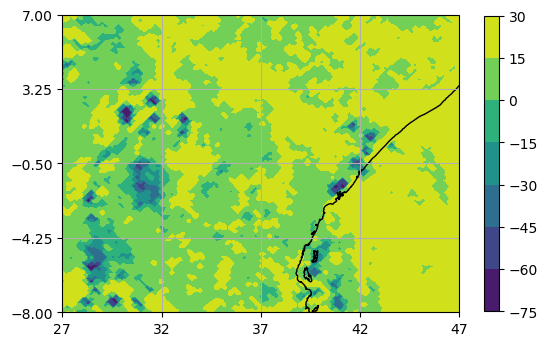

In [6]:

f=plt.figure()

a1 = f.add_subplot(111,projection=ccrs.PlateCarree())
con1 = plt.contourf(lon2D,lat2D,Tb_ref)
a1.grid()
a1.coastlines()
a1.set_yticks(np.linspace(lat2D.min(),lat2D.max(),5))
a1.set_xticks(np.linspace(lon2D.min(),lon2D.max(),5))
plt.colorbar(con1,shrink=0.8)

plt.show()


In [7]:
start_lat = -8 
end_lat = 7 #
start_lon = 26.5 
end_lon = 47 

latmin, latmax = -9, 8
lonmin, lonmax = 26, 48 

tdex = 1740+24*2 # 2020 04 01 12 00
times = [tdex-2, tdex-1, tdex] # np.arange(tdex,tdex+30,1)
Tb=[]
for t in times:
    idx = get_nn_lon_lat_index(
        2**zoom, np.linspace(lonmin, lonmax, int((lonmax-lonmin)/0.1)), np.linspace(latmin, latmax, int((latmax-latmin)/0.1))) 

    #ref_lon_lat = ds.rlut.isel(time=tdex,cell=idx)
    ref_lon_lat = ds.rlut.isel(time=t).sel(cell=idx) # regional
    ref = ref_lon_lat.values
    lon1D = ref_lon_lat.coords['lon'].values
    lat1D = ref_lon_lat.coords['lat'].values
    lon2D, lat2D = np.meshgrid(lon1D, lat1D)
    Tb_ref = olr_to_bt(ref)
    Tb.append(Tb_ref)
    

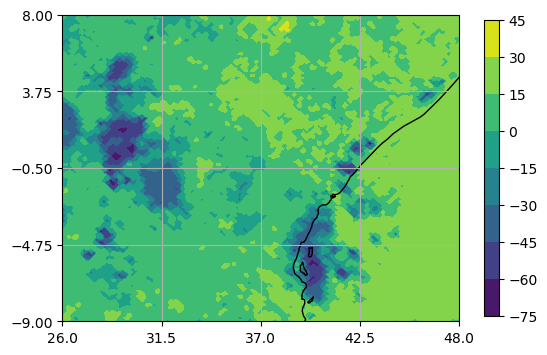

In [9]:

f=plt.figure()

a1 = f.add_subplot(111,projection=ccrs.PlateCarree())
con1 = plt.contourf(lon2D,lat2D,Tb_ref)
a1.grid()
a1.coastlines()
a1.set_yticks(np.linspace(lat2D.min(),lat2D.max(),5))
a1.set_xticks(np.linspace(lon2D.min(),lon2D.max(),5))
plt.colorbar(con1,shrink=0.8)

plt.show()

In [53]:
import pickle
#file_name='um_global_Tb_202004031200.pkl'
#with open(file_name, 'wb') as file:
 #   pickle.dump([lat2D, lon2D, Tb],file)
